In [1]:
import pyrootutils
from pathlib import Path

# Point to your repo root manually
root = pyrootutils.setup_root(
    Path().resolve().parent,  # current working dir
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=False,
)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import filters, morphology, exposure, measure, morphology, segmentation

from src.data_modules.hsi_dermoscopy import HSIDermoscopyDataModule
from src.data_modules.datasets.hsi_dermoscopy import HSIDermoscopyTask

/home/kris/.local/share/mamba/envs/light/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_module = HSIDermoscopyDataModule(data_dir="../data/hsi_dermoscopy",
    task=HSIDermoscopyTask.CLASSIFICATION_MELANOMA_VS_DYSPLASTIC_NEVI,
                                      allowed_labels=[
                                                    # "dysplastic_nevi",
                                                      "melanoma"
                                                      ],
                                      train_val_test_split=[.70, .15, .15],
                                      batch_size=16)
data_module.prepare_data()
data_module.setup()
data_loader = data_module.all_dataloader()
dataset = data_loader.dataset

In [4]:
# get first sample
image, label = dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")

Image shape: (272, 512, 16), Label: 0


In [5]:
def kmeans_segment(image: np.ndarray, n_clusters: int = 3, random_state: int = 42):
    """
    Apply K-means clustering to segment a hyperspectral image.

    Args:
        image (np.ndarray): Hyperspectral cube (H, W, C).
        n_clusters (int): Number of clusters.
        random_state (int): Random state for reproducibility.

    Returns:
        np.ndarray: Cluster segmentation mask (H, W).
    """
    H, W, C = image.shape

    # Flatten to (N_pixels, Bands)
    flat_pixels = image.reshape(-1, C)

    # Normalize per band (optional but helps)
    flat_pixels = (flat_pixels - flat_pixels.mean(axis=0)) / (
        flat_pixels.std(axis=0) + 1e-8
    )

    # Run K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(flat_pixels)

    # Reshape back to (H, W)
    segmentation = labels.reshape(H, W)
    return segmentation

Using sample index: 39


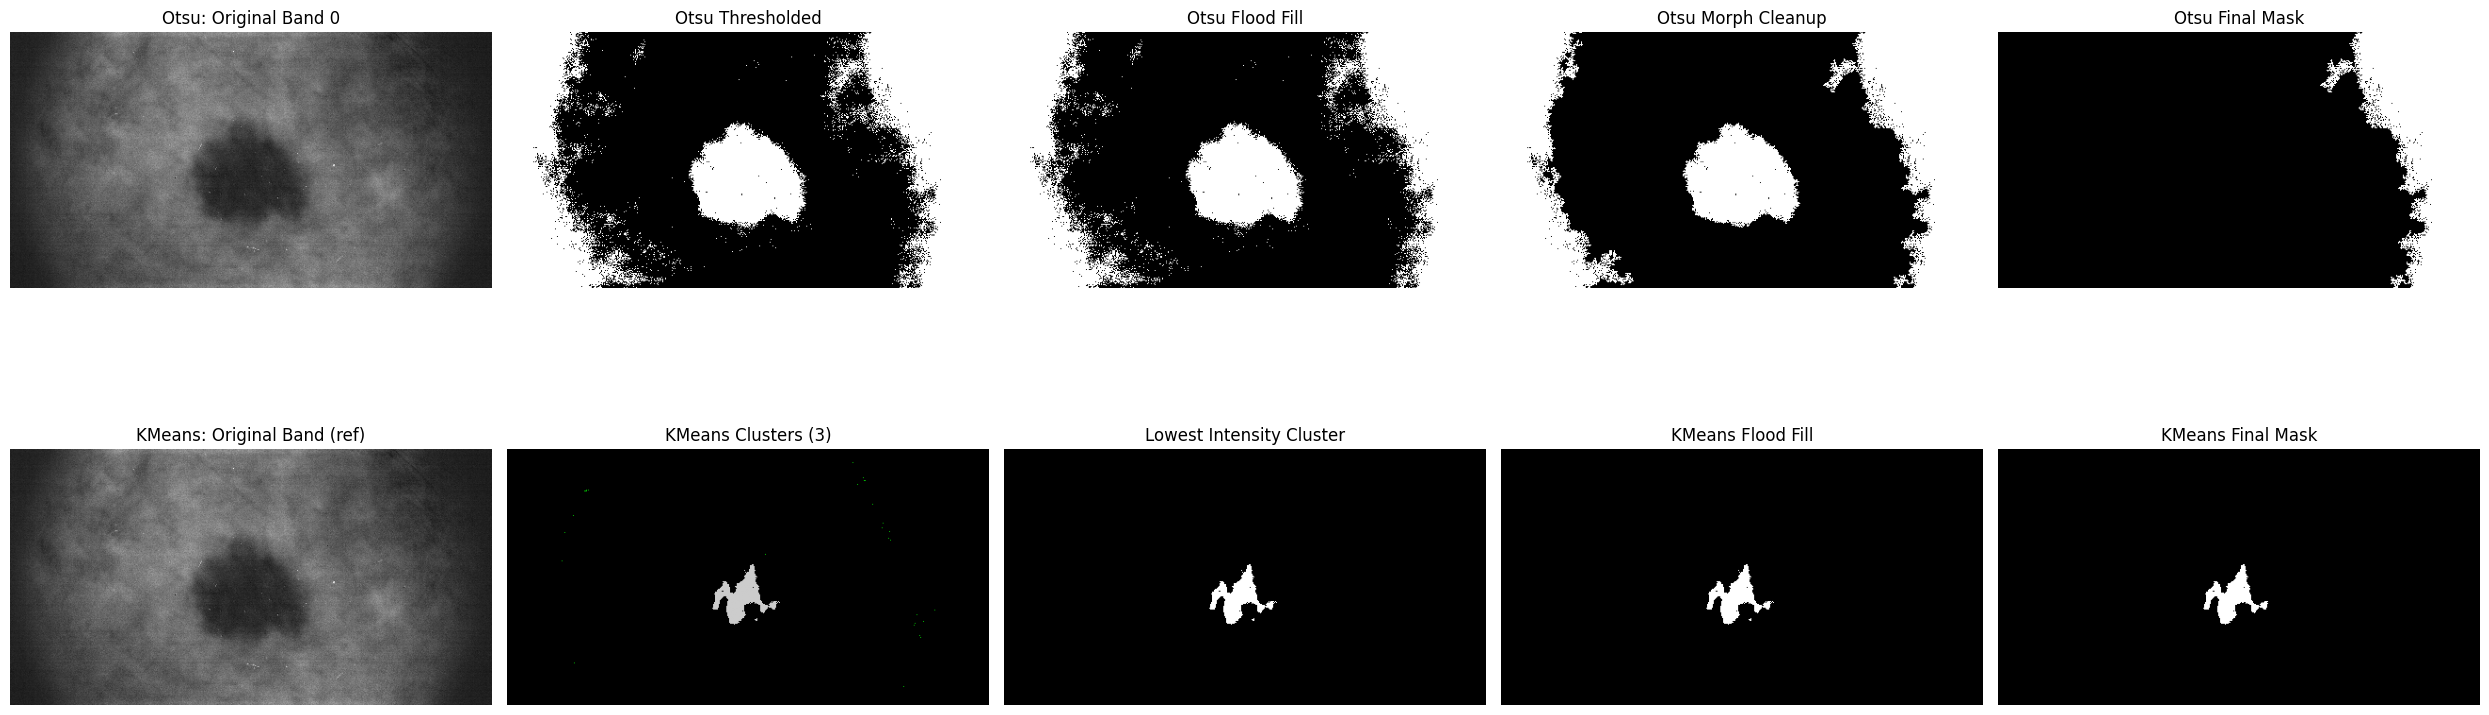

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from skimage.segmentation import flood_fill
from sklearn.cluster import KMeans

def pipeline_otsu(image, band_index=0, apply_morph_clean=True, plot=True):
    """Full step-by-step Otsu segmentation pipeline."""
    selected_band = image[:, :, band_index]

    # Step 1: Otsu threshold
    t = filters.threshold_otsu(selected_band)
    seg_binary = (selected_band <= t).astype(np.uint8)

    # Step 2-4: Fill, morph clean, final mask
    seg_filled, seg_clean, final = floodfill_and_morph(seg_binary)

    if plot:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(selected_band, cmap="gray")
        axes[0].set_title(f"Original Band {band_index}")
        axes[0].axis("off")

        axes[1].imshow(seg_binary, cmap="gray")
        axes[1].set_title("Otsu Thresholded")
        axes[1].axis("off")

        axes[2].imshow(seg_filled, cmap="gray")
        axes[2].set_title("After Border Flood Fill")
        axes[2].axis("off")

        axes[3].imshow(final, cmap="gray")
        axes[3].set_title("Largest Component")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()

    return final


def pipeline_kmeans(image, n_clusters=3, apply_morph_clean=True, plot=True):
    """Full step-by-step KMeans segmentation pipeline."""
    h, w, c = image.shape
    reshaped = image.reshape(-1, c)

    # Step 1: Run KMeans
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(reshaped)
    labels = km.labels_.reshape(h, w)

    # Step 2: Choose lowest mean intensity cluster
    mean_intensities = [image[labels == i].mean() for i in range(labels.max() + 1)]
    lesion_label = np.argmin(mean_intensities)
    seg_lowest = (labels == lesion_label).astype(np.uint8)

    # Step 3-5: Fill, morph clean, final mask
    seg_filled, seg_clean, final = floodfill_and_morph(seg_lowest)

    if plot:
        fig, axes = plt.subplots(1, 5, figsize=(22, 5))

        axes[0].imshow(image[:, :, 0], cmap="gray")
        axes[0].set_title("Original - First Band")
        axes[0].axis("off")

        axes[1].imshow(labels, cmap="nipy_spectral")
        axes[1].set_title(f"KMeans ({n_clusters} clusters)")
        axes[1].axis("off")

        axes[2].imshow(seg_lowest, cmap="gray")
        axes[2].set_title("Lowest Intensity Cluster")
        axes[2].axis("off")

        axes[3].imshow(seg_filled, cmap="gray")
        axes[3].set_title("After Border Flood Fill")
        axes[3].axis("off")

        axes[4].imshow(final, cmap="gray")
        axes[4].set_title("Largest Component")
        axes[4].axis("off")

        plt.tight_layout()
        plt.show()

    return final


def floodfill_and_morph(mask, min_size=50, hole_size=1000):
    """Apply border flood-fill, morphological cleanup, and keep largest component."""
    h, w = mask.shape
    seg_filled = mask.copy()

    # Collect border pixels
    # border_coords = (
    #     [(0, x) for x in range(w)]
    #     + [(h - 1, x) for x in range(w)]
    #     + [(y, 0) for y in range(h)]
    #     + [(y, w - 1) for y in range(h)]
    # )

    # for seed in border_coords:
    #     if seg_filled[seed] == 1:
            # seg_filled = flood_fill(seg_filled, seed_point=seed, new_value=0)

    # Morphological cleanup
    seg_clean = morphology.remove_small_objects(seg_filled.astype(bool), min_size=min_size)
    # seg_clean = morphology.remove_small_holes(seg_clean.astype(bool), area_threshold=hole_size)
    seg_clean = seg_clean.astype(np.uint8)

    # Keep largest connected component
    labeled_mask = measure.label(seg_clean)
    props = measure.regionprops(labeled_mask)
    if len(props) > 0:
        largest_region = max(props, key=lambda r: r.area)
        final = (labeled_mask == largest_region.label).astype(np.uint8)
    else:
        final = np.zeros_like(seg_clean, dtype=np.uint8)

    return seg_filled, seg_clean, final


def comparative_pipeline(image, band_index=0, n_clusters=3):
    """
    Show step-by-step pipelines for Otsu and KMeans side by side.
    """
    h, w, c = image.shape
    selected_band = image[:, :, band_index]

    # ---------- OTSU ----------
    t = filters.threshold_otsu(selected_band)
    seg_binary_otsu = (selected_band <= t).astype(np.uint8)
    seg_filled_otsu, seg_clean_otsu, final_otsu = floodfill_and_morph(seg_binary_otsu)


    # ---------- KMEANS ----------
    reshaped = image.reshape(-1, c)
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(reshaped)
    labels = km.labels_.reshape(h, w)
    labels = segmentation.clear_border(labels)
    mean_intensities = [image[labels == i].mean() for i in range(labels.max() + 1)]
    lesion_label = np.argmin(mean_intensities)
    seg_lowest = (labels == lesion_label).astype(np.uint8)
    seg_filled_km, seg_clean_km, final_km = floodfill_and_morph(seg_lowest)

    # ---------- PLOT ----------
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))

    # --- Otsu row ---
    axes[0, 0].imshow(selected_band, cmap="gray")
    axes[0, 0].set_title(f"Otsu: Original Band {band_index}")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(seg_binary_otsu, cmap="gray")
    axes[0, 1].set_title("Otsu Thresholded")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(seg_filled_otsu, cmap="gray")
    axes[0, 2].set_title("Otsu Flood Fill")
    axes[0, 2].axis("off")

    axes[0, 3].imshow(seg_clean_otsu, cmap="gray")
    axes[0, 3].set_title("Otsu Morph Cleanup")
    axes[0, 3].axis("off")

    axes[0, 4].imshow(final_otsu, cmap="gray")
    axes[0, 4].set_title("Otsu Final Mask")
    axes[0, 4].axis("off")

    # --- KMeans row ---
    axes[1, 0].imshow(selected_band, cmap="gray")
    axes[1, 0].set_title("KMeans: Original Band (ref)")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(labels, cmap="nipy_spectral")
    axes[1, 1].set_title(f"KMeans Clusters ({n_clusters})")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(seg_lowest, cmap="gray")
    axes[1, 2].set_title("Lowest Intensity Cluster")
    axes[1, 2].axis("off")

    axes[1, 3].imshow(seg_filled_km, cmap="gray")
    axes[1, 3].set_title("KMeans Flood Fill")
    axes[1, 3].axis("off")

    axes[1, 4].imshow(final_km, cmap="gray")
    axes[1, 4].set_title("KMeans Final Mask")
    axes[1, 4].axis("off")

    plt.tight_layout()
    plt.show()

    return final_otsu, final_km

# Pick a random image from dataset
idx = np.random.randint(0, len(dataset))
idx = 39
print(f"Using sample index: {idx}")
image, label = dataset[idx]

# Run comparative pipeline
mask_otsu, mask_kmeans = comparative_pipeline(image, band_index=0, n_clusters=3)

Using sample index: 26


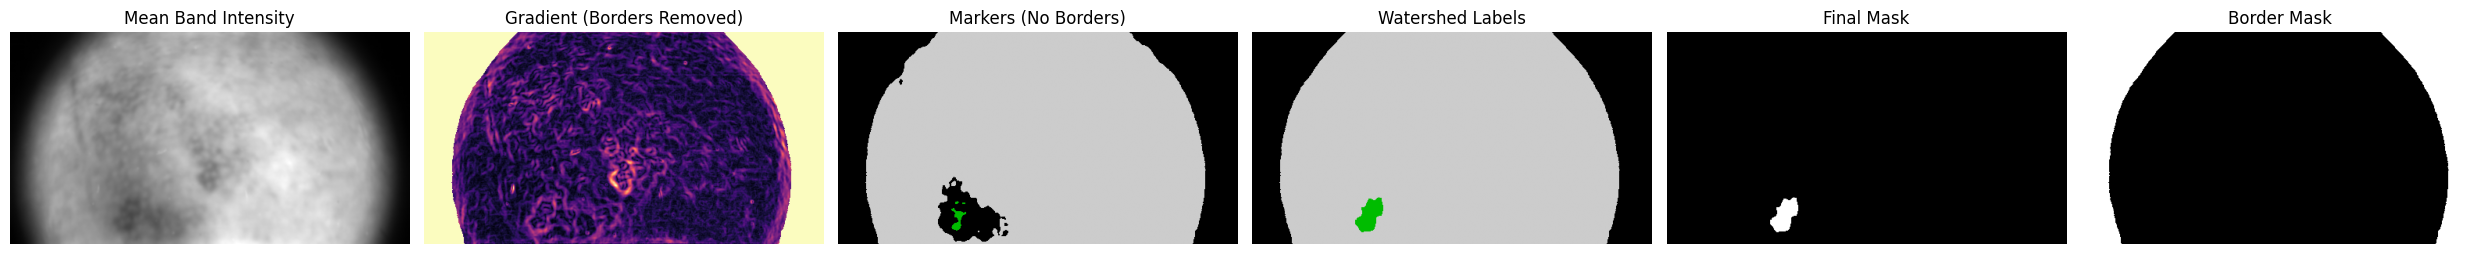

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure, segmentation
from skimage.segmentation import flood_fill
from scipy.ndimage import binary_dilation

def get_border_mask(image, iterations=20, threshold=0.1):
    """
    Compute a border mask by flood-filling the corners, then dilating.
    """
    mean_img = image.mean(axis=-1)
    image_mask = (mean_img < threshold).astype(np.uint8)  # threshold for dark/empty borders
    filled_mask = image_mask.copy()

    h, w = image_mask.shape
    corners = [(0, 0), (0, w - 1), (h - 1, 0), (h - 1, w - 1)]

    # Flood fill from corners
    for c in corners:
        # if filled_mask[c] == 1:
            filled_mask = flood_fill(filled_mask, c, 2)

    border_mask = filled_mask == 2
    dilated_mask = binary_dilation(border_mask, iterations=iterations)

    return dilated_mask

def pipeline_watershed_multiband(image, apply_morph_clean=True, plot=True):
    """
    Watershed segmentation using combined gradient across multispectral bands,
    with both gradient and markers masked to ignore borders.
    """
    h, w, c = image.shape

    # 1. Smooth each band
    smoothed = np.stack(
        [filters.gaussian(image[..., i], sigma=1) for i in range(c)], axis=-1
    )

    # 2. Compute gradients
    gradients = np.stack([filters.sobel(smoothed[..., i]) for i in range(c)], axis=-1)
    gradient_mag = np.sqrt(np.sum(gradients**2, axis=-1))

    # 🔹 Create border mask
    border_mask = get_border_mask(image, iterations=20)

    # 🔹 Remove border influence in gradient
    gradient_mag[border_mask] = np.max(gradient_mag)

    # 3. Generate markers using mean intensity
    mean_band = smoothed.mean(axis=-1)
    thresh = filters.threshold_otsu(mean_band)

    markers = np.zeros_like(mean_band, dtype=np.int32)
    markers[mean_band < thresh * 0.8] = 1  # background
    markers[mean_band > thresh * 1.1] = 2  # foreground

    # 🔹 Critical fix: remove markers in border region
    markers[border_mask] = 0   # ensure no seeding inside borders

    # 4. Apply watershed only outside borders
    labels = segmentation.watershed(
        gradient_mag, markers, mask=~border_mask
    )

    # 5. Extract lesion mask
    seg_mask = (labels == 2).astype(np.uint8)

    # 6. Morphological cleaning
    if apply_morph_clean:
        seg_mask = morphology.remove_small_objects(seg_mask.astype(bool), min_size=50)
        seg_mask = morphology.remove_small_holes(seg_mask.astype(bool), area_threshold=500)
        seg_mask = seg_mask.astype(np.uint8)

    # 7. Largest connected component
    labeled = measure.label(seg_mask)
    props = measure.regionprops(labeled)
    if props:
        largest = max(props, key=lambda r: r.area)
        final_mask = (labeled == largest.label).astype(np.uint8)
    else:
        final_mask = np.zeros_like(seg_mask)

    final_mask = 1 - final_mask  # invert mask if needed
    final_mask[border_mask] = 0  # ensure borders are also masked

    # --- Debug plots ---
    if plot:
        fig, axes = plt.subplots(1, 6, figsize=(25, 5))
        axes[0].imshow(mean_band, cmap="gray"); axes[0].set_title("Mean Band Intensity"); axes[0].axis("off")
        axes[1].imshow(gradient_mag, cmap="magma"); axes[1].set_title("Gradient (Borders Removed)"); axes[1].axis("off")
        axes[2].imshow(markers, cmap="nipy_spectral"); axes[2].set_title("Markers (No Borders)"); axes[2].axis("off")
        axes[3].imshow(labels, cmap="nipy_spectral"); axes[3].set_title("Watershed Labels"); axes[3].axis("off")
        axes[4].imshow(final_mask, cmap="gray"); axes[4].set_title("Final Mask"); axes[4].axis("off")
        axes[5].imshow(border_mask, cmap="gray"); axes[5].set_title("Border Mask"); axes[5].axis("off")
        plt.tight_layout(); plt.show()

    return final_mask

idx = np.random.randint(0, len(dataset))
idx = 26
# Ficam horríveis: 16, 29, 35, 74
print(f"Using sample index: {idx}")
image, label = dataset[idx]

mask_watershed = pipeline_watershed_multiband(image, plot=True, apply_morph_clean=False)

Using sample index: 51


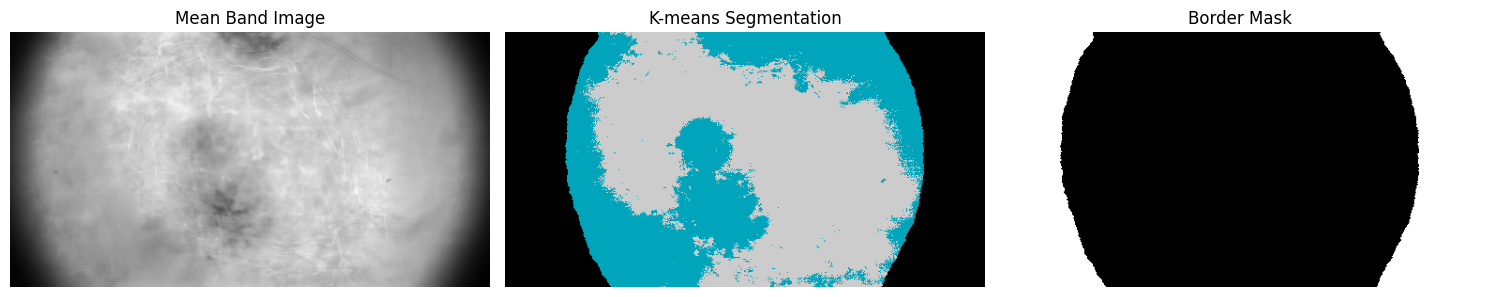

In [8]:
from sklearn.cluster import KMeans

def kmeans_segment_with_borders(
    image: np.ndarray,
    n_clusters: int = 3,
    random_state: int = 42,
    border_iterations: int = 20,
):
    """
    Apply K-means clustering to segment a hyperspectral image,
    with border regions set to the maximum integer value 
    allowed by the dtype AND relabeled as -1 in the output.

    Args:
        image (np.ndarray): Hyperspectral cube (H, W, C).
        n_clusters (int): Number of clusters.
        random_state (int): Random state for reproducibility.
        border_iterations (int): Border dilation iterations.

    Returns:
        np.ndarray: Cluster segmentation mask (H, W) with borders = -1.
    """
    H, W, C = image.shape

    # 🔹 Step 1: Compute border mask
    border_mask = get_border_mask(image, iterations=border_iterations)

    # 🔹 Step 2: Find maximum representable integer value for dtype
    if np.issubdtype(image.dtype, np.integer):
        max_val = np.iinfo(image.dtype).max
    else:
        # If float, fallback to actual observed max pixel
        max_val = image.max()

    # 🔹 Step 3: Copy image and set border pixels to max dtype value
    image_with_borders = image.copy()
    image_with_borders[border_mask] = max_val

    # 🔹 Step 4: Flatten all pixels for KMeans
    flat_pixels = image_with_borders.reshape(-1, C)

    # 🔹 Step 5: Normalize features per band
    flat_pixels = (flat_pixels - flat_pixels.mean(axis=0)) / (
        flat_pixels.std(axis=0) + 1e-8
    )

    # 🔹 Step 6: Run K-means on ALL pixels
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(flat_pixels)

    # 🔹 Step 7: Restore shape
    segmentation = labels.reshape(H, W)

    # 🔹 Step 8: Force border pixels to -1
    segmentation[border_mask] = -1

    return segmentation, border_mask

idx = np.random.randint(0, len(dataset))
idx = 51
# Ficam horríveis: 16, 29, 35, 74
print(f"Using sample index: {idx}")
image, label = dataset[idx]

segmentation_kmeans, border_mask = kmeans_segment_with_borders(image, n_clusters=3, border_iterations=50)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image.mean(axis=-1), cmap="gray")
plt.title("Mean Band Image"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(segmentation_kmeans, cmap="nipy_spectral")
plt.title("K-means Segmentation"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(border_mask, cmap="gray")
plt.title("Border Mask"); plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
(40 / len(dataset)) * 100, (12 / 85) * 100

(47.05882352941176, 14.117647058823529)

Using sample index: 22


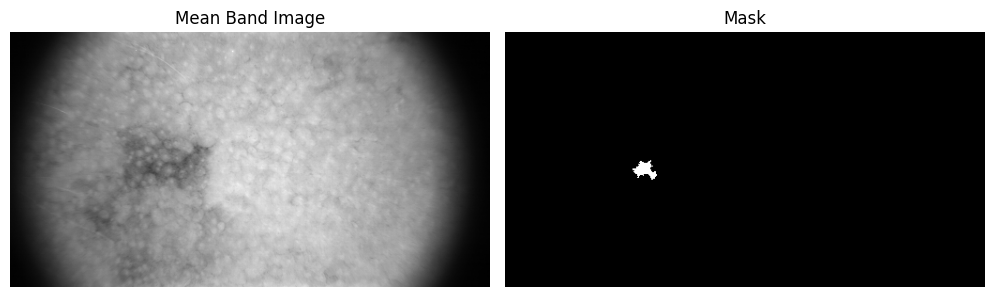

In [10]:
idx = np.random.randint(0, len(dataset))
idx = 22
# Borda não capturada:
# Segmentation ruim: 22, 63, 28, 84, 23, 32, 65

# Seg ruim nevi: 145, 56, 143, 18, 175, 76, 2, 75, 150, 48, 31, 82, 148, 181, 23, 18,
# 126, 38, 55, 44, 26, 31, 128, 174, 26, 55, 45, 65, 60, 157, 154, 46, 63, 42
# Segmentation marromeno nevi: 166, 94 (pegou uma mancha menos escura)
# Segmentation marromeno: 53, 12, 14
print(f"Using sample index: {idx}")
image, label = dataset[idx]

# first attempt with threshold=0.06
border_mask = get_border_mask(image, iterations=90, threshold=0.06)

# Try Otsu thresholding on band mean
image_mean = image.mean(axis=-1)  # or image[..., 10] if you want
t = filters.threshold_otsu(image_mean)
image_mask = (image_mean <= t).astype(np.uint8)

# Apply border masking
image_mask[border_mask] = 0

# Remove small objects
# connect objects
# image_mask = morphology.binary_closing(image_mask, morphology.disk(2))
image_mask = morphology.remove_small_objects(image_mask.astype(bool), min_size=60)

# Keep largest connected component
labeled = measure.label(image_mask)
props = measure.regionprops(labeled)

# Fallback condition: if nothing found, retry with border mask threshold=0.1
if not props:
    print("No components found — retrying with border_mask threshold=0.1")
    border_mask = get_border_mask(image, iterations=120, threshold=0.1)

    image_mask = (image_mean <= t).astype(np.uint8)
    image_mask[border_mask] = 0
    image_mask = morphology.remove_small_objects(image_mask.astype(bool), min_size=60)

    labeled = measure.label(image_mask)
    props = measure.regionprops(labeled)

# If now there is something, keep largest
if props:
    largest = max(props, key=lambda r: r.area)
    image_mask = (labeled == largest.label).astype(np.uint8)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image_mean, cmap="gray")
plt.title("Mean Band Image"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(image_mask, cmap="gray")
plt.title("Mask"); plt.axis("off")

plt.tight_layout()
plt.show()

Using sample index: 65


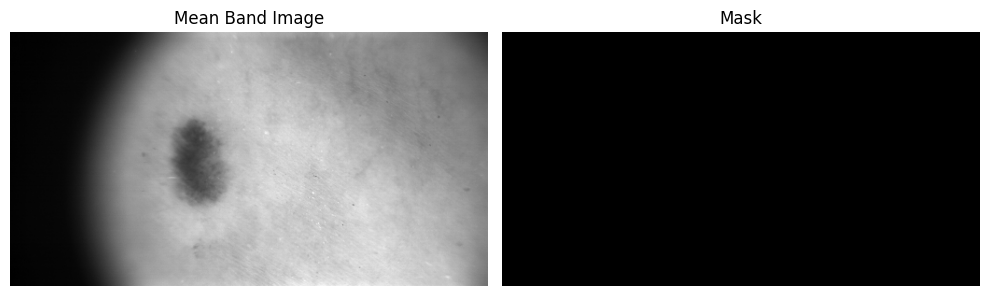

In [11]:
idx = np.random.randint(0, len(dataset))
idx = 65
print(f"Using sample index: {idx}")
image, label = dataset[idx]



image_mean = image.mean(axis=-1)  # or image[..., 10] if you want

# normalize image_mean to [0, 1]
image_mean = (image_mean - image_mean.min()) / (image_mean.max() - image_mean.min() + 1e-8)

# normalize multispectral image band-wise to [0, 1]
# image = (image - image.min(axis=(0,1))) / (image.max(axis=(0,1)) - image.min(axis=(0,1)) + 1e-8)

image_mask = image_mean < 0.2
border_mask = get_border_mask(image, iterations=1, threshold=0.013)
image_mask = border_mask
# image_mask[border_mask] = 0

# plot image and mask
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_mean, cmap="gray")
plt.title("Mean Band Image"); plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(image_mask, cmap="gray")
plt.title("Mask"); plt.axis("off")
plt.tight_layout()
plt.show()

Using sample index: 32


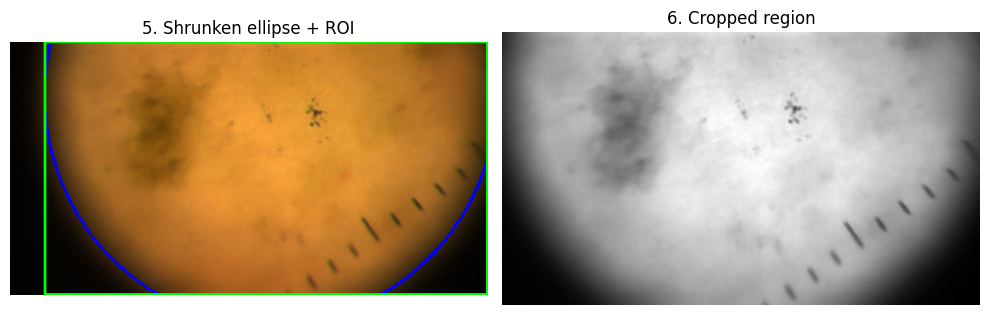

In [12]:
import numpy as np
import cv2
from scipy import ndimage as ndi
import matplotlib.pyplot as plt


# -------------------- Preprocessing --------------------
def preprocess_sample(image, channels=(0, 10, 12)):
    """Select channels, apply median filter, and rescale to 8-bit."""
    image_sel = image[..., list(channels)]
    image_med = ndi.median_filter(image_sel, size=(3, 3, 3))
    image_rescaled = (
        (image_med - image_med.min()) / (image_med.max() - image_med.min()) * 255
    ).astype(np.uint8)
    return image_rescaled


# -------------------- Algorithm --------------------
def debug_crop_inside_ellipse(
    image,
    ellipse_shrink_factor=0.8,
    square_shrink_factor=1.0,
    method="square",  # "square" or "bbox"
):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Step 1: threshold
    _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    # Step 2: all contours
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

    # Step 3: largest contour
    largest = max(contours, key=cv2.contourArea)
    largest_img = contour_img.copy()
    cv2.drawContours(largest_img, [largest], -1, (0, 0, 255), 2)

    # Step 4: fitted ellipse
    ellipse = cv2.fitEllipse(largest)
    mask_orig = np.zeros_like(gray)
    cv2.ellipse(mask_orig, ellipse, 255, -1)

    ellipse_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.ellipse(ellipse_img, ellipse, (255, 0, 0), 2)

    # Step 5: shrink ellipse
    (x, y), (MA, ma), angle = ellipse
    MA_shrunk, ma_shrunk = MA * ellipse_shrink_factor, ma * ellipse_shrink_factor
    ellipse_shrunk = ((x, y), (MA_shrunk, ma_shrunk), angle)

    # Draw ellipse
    ellipse_bbox_img = image.copy()
    cv2.ellipse(ellipse_bbox_img, ellipse_shrunk, (255, 0, 0), 2)

    # Step 6: crop depending on method
    if method == "square":
        a = MA_shrunk / 2.0
        b = ma_shrunk / 2.0
        s = int(min(np.sqrt(2) * a, np.sqrt(2) * b) * square_shrink_factor)

        x_min = int(x - s / 2)
        x_max = int(x + s / 2)
        y_min = int(y - s / 2)
        y_max = int(y + s / 2)

        cv2.rectangle(ellipse_bbox_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cropped = image[y_min:y_max, x_min:x_max]

    elif method == "bbox":
        mask_shrunk = np.zeros_like(gray)
        cv2.ellipse(mask_shrunk, ellipse_shrunk, 255, -1)

        ys, xs = np.where(mask_shrunk == 255)
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        cx = (x_min + x_max) / 2
        cy = (y_min + y_max) / 2
        w = (x_max - x_min) * square_shrink_factor
        h = (y_max - y_min) * square_shrink_factor

        x_min = int(cx - w / 2)
        x_max = int(cx + w / 2)
        y_min = int(cy - h / 2)
        y_max = int(cy + h / 2)

        cv2.rectangle(ellipse_bbox_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cropped = image[y_min:y_max, x_min:x_max]

    else:
        raise ValueError("method must be 'square' or 'bbox'")

    return (
        thresh,
        contour_img,
        largest_img,
        mask_orig,
        ellipse_bbox_img,
        cropped,
    )


# -------------------- Visualization --------------------
def visualize_results(results):
    (
        _,
        _,
        _,
        _,
        ellipse_bbox_img,
        cropped,
    ) = results

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Step 5: ellipse + bbox/square
    axes[0].imshow(ellipse_bbox_img[..., ::-1])
    axes[0].set_title("5. Shrunken ellipse + ROI")
    axes[0].axis("off")

    # Step 6: cropped region
    axes[1].imshow(cropped.mean(axis=-1), cmap="gray")
    axes[1].set_title("6. Cropped region")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# -------------------- Example Usage --------------------
# Pick sample
idx = np.random.randint(0, len(dataset))
idx = 32
print(f"Using sample index: {idx}")
image, label = dataset[idx]

# Preprocess once
image_rescaled = preprocess_sample(image)

cropped = image_rescaled.copy()

# Run algorithm multiple times with different parameters
for ellipse_shrink, square_shrink, method in [(1.0, 1, "bbox"),
                                            #   (1.0, 0.9, "bbox"),
                                            #   (1.0, 0.9, "bbox")
                                              ]:
    try:
        results = debug_crop_inside_ellipse(
            cropped, ellipse_shrink_factor=ellipse_shrink, square_shrink_factor=square_shrink, method=method
        )
        (
            thresh,
            contour_img,
            largest_img,
            mask_orig,
            ellipse_bbox_img,
            cropped,
        ) = results
    except Exception as e:
        print(f"Error with params ellipse_shrink={ellipse_shrink}, square_shrink={square_shrink}, method={method}: {e}")
        break

visualize_results(results)

Using sample index: 56


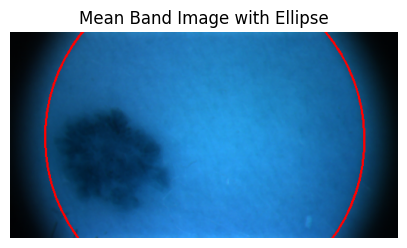

In [ ]:
def preprocess_sample(image, channels=(0, 10, 12)):
    """Select channels, apply median filter, and rescale to 8-bit."""
    image_sel = image[..., list(channels)]
    image_med = ndi.median_filter(image_sel, size=(3, 3, 3))
    image_rescaled = (
        (image_med - image_med.min()) / (image_med.max() - image_med.min()) * 255
    ).astype(np.uint8)
    return image_rescaled

def get_ellipse_mask(
    image,
    ellipse_shrink_factor=0.8
):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Step 1: threshold
    _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    # Step 2: all contours
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

    # Step 3: largest contour
    largest = max(contours, key=cv2.contourArea)
    largest_img = contour_img.copy()
    cv2.drawContours(largest_img, [largest], -1, (0, 0, 255), 2)

    # Step 4: fitted ellipse
    ellipse = cv2.fitEllipse(largest)
    mask_orig = np.zeros_like(gray)
    cv2.ellipse(mask_orig, ellipse, 255, -1)

    ellipse_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.ellipse(ellipse_img, ellipse, (255, 0, 0), 2)

    # Step 5: shrink ellipse
    (x, y), (MA, ma), angle = ellipse
    MA_shrunk, ma_shrunk = MA * ellipse_shrink_factor, ma * ellipse_shrink_factor
    ellipse_shrunk = ((x, y), (MA_shrunk, ma_shrunk), angle)

    return ellipse_shrunk

# Pick sample
idx = np.random.randint(0, len(dataset))
# idx = 32
print(f"Using sample index: {idx}")
image, label = dataset[idx]

# Preprocess once
image_rescaled = preprocess_sample(image)

ellipse_shrunk = get_ellipse_mask(image_rescaled, ellipse_shrink_factor=0.9)

cv2.ellipse(image_rescaled, ellipse_shrunk, (255, 0, 0), 2)

# bad ellipsis: 74
# Show with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(image_rescaled)
plt.title("Mean Band Image with Ellipse")
plt.axis("off")
plt.show()

Using sample index: 13
Reference spectrum L_PAT: 0.16263437 0.034851097 0.384089


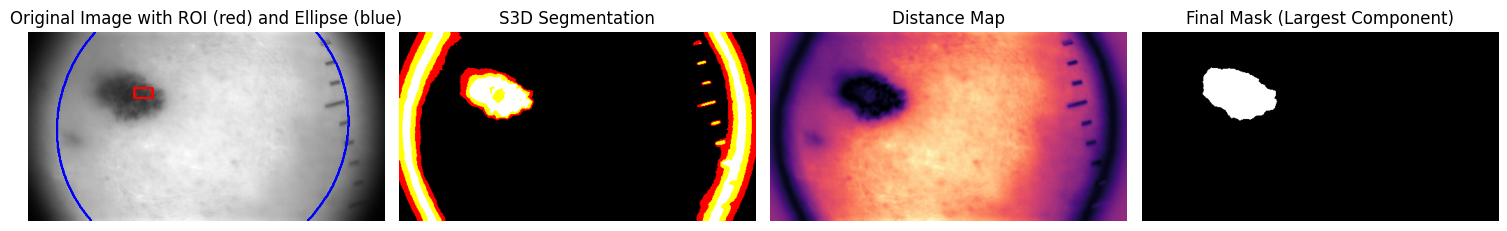

In [ ]:
import numpy as np
from scipy.ndimage import median_filter

def preprocess_sample(image, channels=(0, 10, 12)):
    """Select channels, apply median filter, and rescale to 8-bit."""
    if image.shape[2] != 3:
        image_sel = image[..., list(channels)]
    else:
        image_sel = image
    image_med = ndi.median_filter(image_sel, size=(3, 3, 3))
    image_rescaled = (
        (image_med - image_med.min()) / (image_med.max() - image_med.min()) * 255
    ).astype(np.uint8)
    return image_rescaled

def get_ellipse_mask(
    image,
    ellipse_shrink_factor=0.8
):
    image = preprocess_sample(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Step 1: threshold
    _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    # Step 2: all contours
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

    # Step 3: largest contour
    largest = max(contours, key=cv2.contourArea)
    largest_img = contour_img.copy()
    cv2.drawContours(largest_img, [largest], -1, (0, 0, 255), 2)

    # Step 4: fitted ellipse
    ellipse = cv2.fitEllipse(largest)
    mask_orig = np.zeros_like(gray)
    cv2.ellipse(mask_orig, ellipse, 255, -1)

    ellipse_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.ellipse(ellipse_img, ellipse, (255, 0, 0), 2)

    # Step 5: shrink ellipse
    (x, y), (MA, ma), angle = ellipse
    MA_shrunk, ma_shrunk = MA * ellipse_shrink_factor, ma * ellipse_shrink_factor
    ellipse_shrunk = ((x, y), (MA_shrunk, ma_shrunk), angle)

    mask_shrunk = np.zeros_like(gray)
    cv2.ellipse(mask_shrunk, ellipse_shrunk, 255, -1)
    return mask_shrunk

def s3d_segmentation(data_cube, roi_mask, thresholds=(0.3, 0.2, 0.1)):
    """
    Implements the 3D segmentation method (S3D) from Koprowski & Olczyk (2016).

    Args:
        data_cube: numpy array of shape (M, N, I), the hyperspectral cube
        roi_mask: numpy array of shape (M, N), binary mask selecting ROI for reference spectrum
        thresholds: tuple of thresholds (pr1, pr2, pr3) as percentages

    Returns:
        segmented_image: numpy array (M, N, 3) segmentation mask with RGB coding
    """
    M, N, I = data_cube.shape

    # 1. Compute reference spectrum L_PAT(i)
    roi_pixels = data_cube[roi_mask > 0]  # shape: num_pixels x I
    L_PAT = roi_pixels.mean(axis=0)
    print("Reference spectrum L_PAT:", L_PAT.mean(), L_PAT.min(), L_PAT.max())

    # 2. Difference cube: LV(m,n,i)
    LV = data_cube - L_PAT

    # 3. Apply 3D median filtering (spatial + spectral)
    LV_filtered = median_filter(LV, size=(3, 3, 3))

    # 4. Compute normalized similarity measure per pixel
    # Euclidean distance in spectral space
    distances = np.linalg.norm(LV_filtered, axis=2)
    distances = distances / distances.max()

    # 5. Thresholding to create segmentation layers
    segmented_image = np.zeros((M, N, 3))  # RGB encoding

    for channel, pr in enumerate(thresholds):
        mask = distances < pr
        segmented_image[..., channel] = mask.astype(float)

    return segmented_image, distances


# Pick sample
idx = np.random.randint(0, len(dataset))
idx = 13
print(f"Using sample index: {idx}")
image, label = dataset[idx]

# filter to get only bands 0, 12 and 13

# create roi_mask from two points
m, n, _ = image.shape
roi_coords = {
    "m_start": int(m * 0.3), "m_end": int(m * 0.35),
    "n_start": int(n * 0.3), "n_end": int(n * 0.35)
}
roi_slice = (slice(roi_coords["m_start"], roi_coords["m_end"]),
                slice(roi_coords["n_start"], roi_coords["n_end"]))

# create roi_mask
roi_mask = np.zeros((m, n), dtype=np.uint8)
roi_mask[roi_slice] = 1

# image = image[..., [0, 12, 13]]
seg_img, dist = s3d_segmentation(image, roi_mask)

ellipse_mask = get_ellipse_mask(image, ellipse_shrink_factor=0.85)

# final_mask is binary, where all values larger than 0 are set to 1
final_mask = ~(dist > 0.3)
# close small holes
final_mask[ellipse_mask == 0] = 0
final_mask = morphology.remove_small_holes(final_mask, area_threshold=500)

# get largest connected component of seg_img channel 0 as final mask
labeled = measure.label(final_mask)
props = measure.regionprops(labeled)
if props:
    largest = max(props, key=lambda r: r.area)
    final_mask = (labeled == largest.label).astype(np.uint8)
else:
    final_mask = np.zeros_like(seg_img[..., 0], dtype=np.uint8)

# plot original image with roi_mask the ellipse mask, s3d segmentation and distance map all on different subplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(image.mean(axis=-1), cmap="gray")
plt.contour(roi_mask, colors='r', linewidths=1)
plt.contour(ellipse_mask, colors='b', linewidths=1)
plt.title("Original Image with ROI (red) and Ellipse (blue)")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(seg_img)
plt.title("S3D Segmentation")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(dist, cmap="magma")
plt.title("Distance Map")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(final_mask, cmap="gray")
plt.title("Final Mask (Largest Component)")
plt.axis("off")
plt.tight_layout()
plt.show()

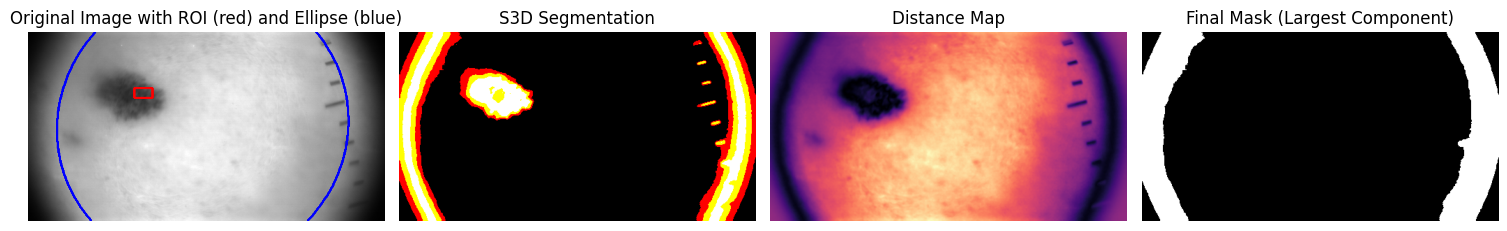

In [45]:
# remove pixels outside ellipse mask
# seg_img[ellipse_mask == 0] = 0

# get largest connected component of seg_img channel 0 as final mask
# labeled = measure.label(seg_img[..., 0] > 0)
# props = measure.regionprops(labeled)
# if props:
#     largest = max(props, key=lambda r: r.area)
#     final_mask = (labeled == largest.label).astype(np.uint8)
# else:
#     final_mask = np.zeros_like(seg_img[..., 0], dtype=np.uint8)

# final_mask is binary, where all values larger than 0 are set to 1
final_mask = (seg_img[..., 0] > 0).astype(np.uint8)

# load lesion.npy and remove it from final_mask
lesion = np.load("lesion.npy")
final_mask[lesion == 1] = 0

# remove small objects from final_mask
final_mask = morphology.remove_small_objects(final_mask.astype(bool), min_size=150).astype(np.uint8)

# save final_mask as border.npy
np.save("border.npy", final_mask)

# plot original image with roi_mask the ellipse mask, s3d segmentation and distance map all on different subplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(image.mean(axis=-1), cmap="gray")
plt.contour(roi_mask, colors='r', linewidths=1)
plt.contour(ellipse_mask, colors='b', linewidths=1)
plt.title("Original Image with ROI (red) and Ellipse (blue)")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(seg_img)
plt.title("S3D Segmentation")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(dist, cmap="magma")
plt.title("Distance Map")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(final_mask, cmap="gray")
plt.title("Final Mask (Largest Component)")
plt.axis("off")
plt.tight_layout()
plt.show()

Using sample index: 13


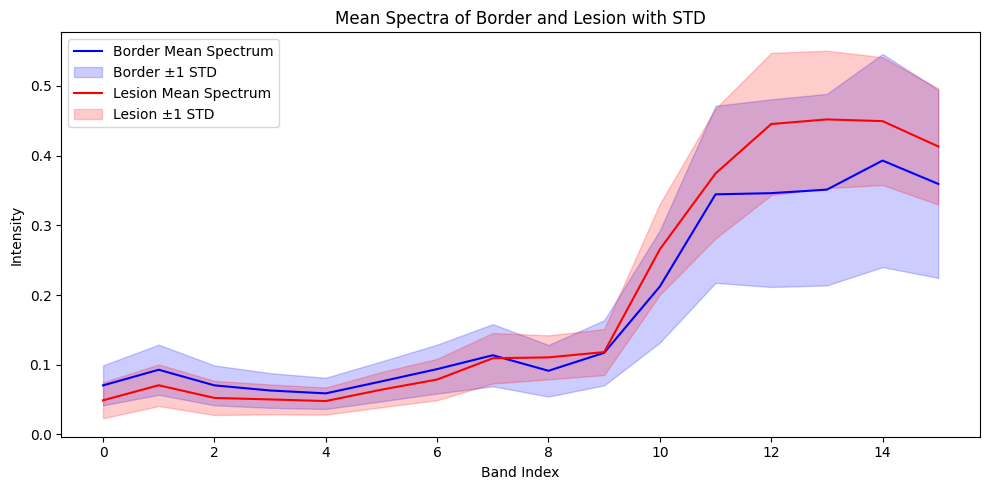

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Pick sample
idx = np.random.randint(0, len(dataset))
idx = 13
print(f"Using sample index: {idx}")
image, label = dataset[idx]

# load border.npy and lesion.npy
border = np.load("border.npy")
lesion = np.load("lesion.npy")

# get the mean & std of every band for each mask
border_img = image[border == 1]
lesion_img = image[lesion == 1]

border_mean = border_img.mean(axis=0)
lesion_mean = lesion_img.mean(axis=0)

border_std = border_img.std(axis=0)
lesion_std = lesion_img.std(axis=0)

bands = np.arange(len(border_mean))

# plot mean spectra with std shading
plt.figure(figsize=(10, 5))
plt.plot(bands, border_mean, label="Border Mean Spectrum", color="blue")
plt.fill_between(
    bands,
    border_mean - border_std,
    border_mean + border_std,
    color="blue",
    alpha=0.2,
    label="Border ±1 STD"
)

plt.plot(bands, lesion_mean, label="Lesion Mean Spectrum", color="red")
plt.fill_between(
    bands,
    lesion_mean - lesion_std,
    lesion_mean + lesion_std,
    color="red",
    alpha=0.2,
    label="Lesion ±1 STD"
)

plt.title("Mean Spectra of Border and Lesion with STD")
plt.xlabel("Band Index")
plt.ylabel("Intensity")
plt.legend()
plt.tight_layout()
plt.show()

Top 3 discriminative bands (by Fisher score): [13 12  0]
Scores: [0.3548881  0.34482014 0.30778062]


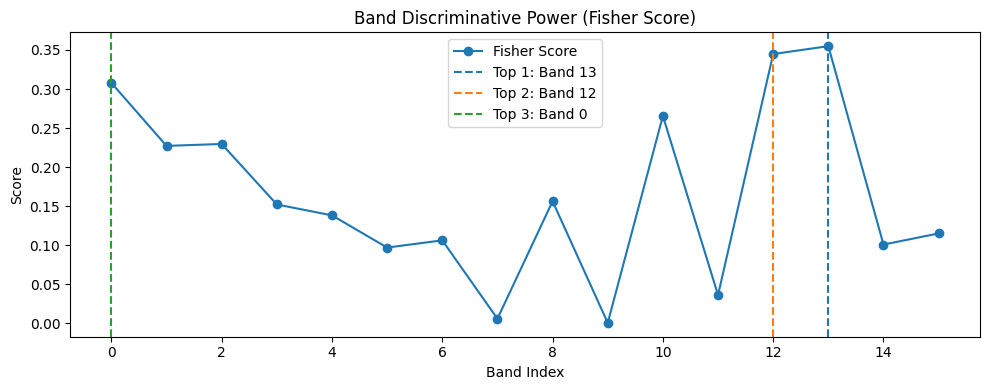

In [53]:
# Fisher score per band
fisher_score = (border_mean - lesion_mean) ** 2 / (
    border_std**2 + lesion_std**2 + 1e-10  # small epsilon to avoid /0
)

# Get top 3 most discriminative bands
top_k = 3
top_indices = np.argsort(fisher_score)[-top_k:][::-1]  # sort descending
print(f"Top {top_k} discriminative bands (by Fisher score): {top_indices}")
print("Scores:", fisher_score[top_indices])

# Optional: plot scores with top 3 highlighted
plt.figure(figsize=(10, 4))
plt.plot(bands, fisher_score, marker="o", label="Fisher Score")

# Highlight top 3
for i, b in enumerate(top_indices):
    plt.axvline(b, linestyle="--", color=f"C{i}", 
                label=f"Top {i+1}: Band {b}")

plt.title("Band Discriminative Power (Fisher Score)")
plt.xlabel("Band Index")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()